# 1 - Introdução do que faremos

## 1.1 - Introdução Regressão Linear Múltipla

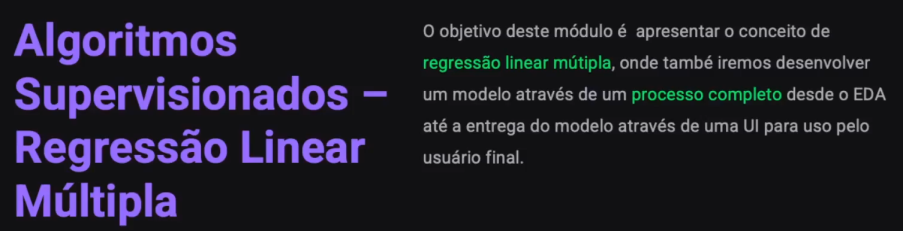

- Vamos recapitular o conceito de regressão linear simples e introduzir a regressão linear múltipla. 
- Na regressão linear simples, temos uma equação da reta que nos permite prever o valor de y com base em um coeficiente y-intercept e um coeficiente multiplicado pelo valor de x. 
- Na regressão linear múltipla, temos mais de um coeficiente, pois temos mais de uma variável independente. 
- Visualmente, isso significa que em vez de uma reta, temos um hiperplano em um espaço tridimensional. 
- O objetivo é encontrar o melhor hiperplano que minimize a soma dos quadrados dos erros entre os valores reais e os valores previstos. 
- Vamos explorar esse conceito em nosso projeto, onde teremos mais de uma variável independente para prever uma variável dependente.

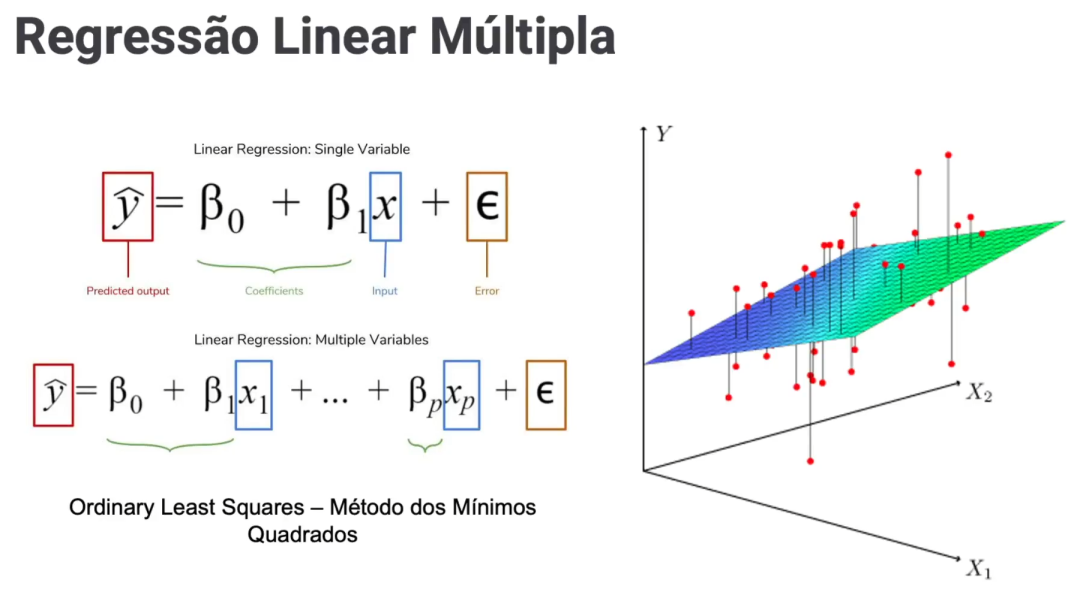

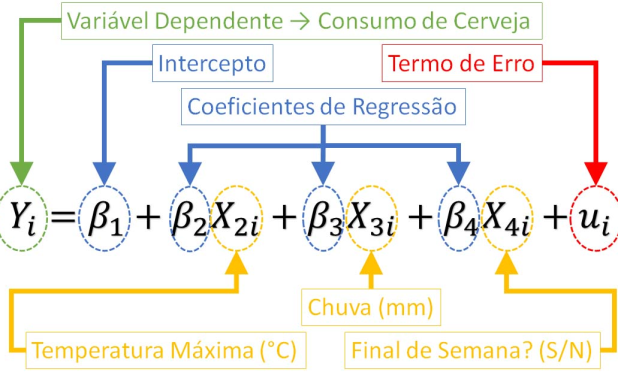

# 2 - Projeto Modelo Colesterol 

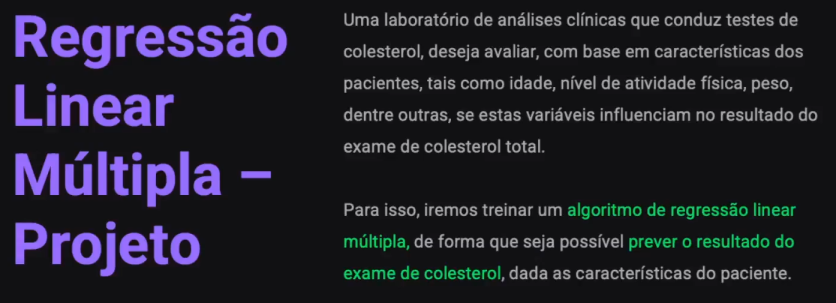

## 2.1 - Descição do Problema
- Precisamos desenvolver um modelo para um laboratório de análises clínicas que realiza testes de colesterol. 
- Objetivo é avaliar se características dos pacientes, como idade, nível de atividade física e peso, podem influenciar nos resultados do exame de colesterol total. 
- Vamos utilizar um algoritmo de regressão linear múltipla para prever o resultado do exame com base nessas características. 
- O processo será semelhante ao que fizemos no módulo anterior de regressão linear simples, como:
    1. carregar os dados, 
    2. realizar uma análise exploratória, 
    3. preparar o dataset, 
    4. treinar o modelo, 
    5. validar o modelo, 
    6. salvar para uso futuro.

## 2.2 - Processos do Projeto

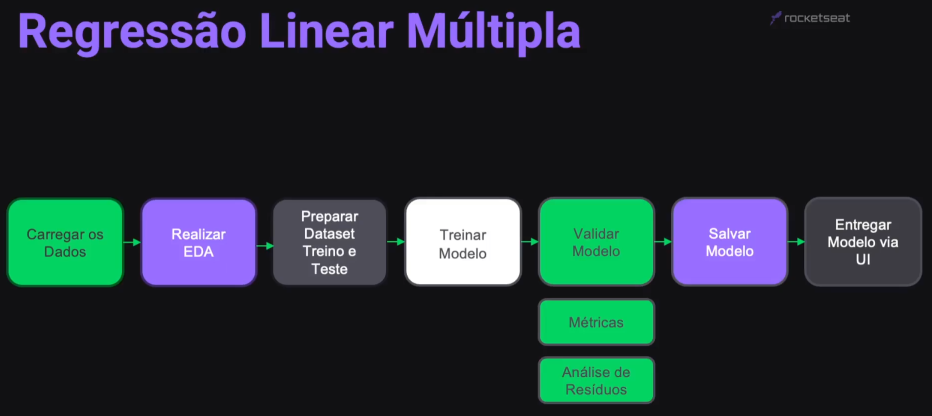

# 3 - Análise Exploratória de Dados
Criaremos uma cópia do DF original para DF EDA

## 3.1 - Importação Bibliotecas

In [2]:
# pip install pingouin

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import zscore, shapiro, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors, het_goldfeldquandt
import pingouin as pg
import joblib

## 3.2 - Carga dos Dados
- Ao carregar os dados desse projeto veremos a importância de trabalhar com nomes de colunas mais técnicos em um DataFrame. 
- Isso facilita a referência e evita confusões com acentuação, maiúsculas e minúsculas. 
- Aprenderemos a renomear as colunas usando o atributo "columns" do DataFrame, atribuindo uma lista com os novos nomes das colunas desejadas. 
- Também aprendemos sobre o conceito de Bucketing, que consiste em transformar variáveis numéricas em variáveis categóricas para análises específicas. 
- Para isso, faremos cópias do DataFrame original para trabalhar na análise exploratória e no Bucketing, deixando o DataFrame original intacto para o treinamento do modelo.

### 3.2.1 - Carregando Dataset e Obtendo Informaçõea

In [4]:
# Carregar dataset
df_colesterol = pd.read_csv('dataset_colesterol.csv')

In [5]:
df_colesterol.head()

,Id,Grupo Sanguíneo,Fumante,Nível de Atividade,Idade,Peso,Altura,Colesterol
0,1,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,2,A,Não,Moderado,68.0,105.0,184.0,236.98
2,3,O,Não,Alto,25.0,64.8,180.0,161.79
3,4,A,Não,Alto,43.0,120.2,167.0,336.24
4,5,AB,Não,Baixo,79.0,88.5,175.0,226.23


In [6]:
# Informações do dataset
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1000 non-null   int64  
 1   Grupo Sanguíneo     996 non-null    object 
 2   Fumante             997 non-null    object 
 3   Nível de Atividade  996 non-null    object 
 4   Idade               997 non-null    float64
 5   Peso                997 non-null    float64
 6   Altura              997 non-null    float64
 7   Colesterol          1000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 62.6+ KB


In [7]:
# Remover coluna Id
df_colesterol.drop(columns=['Id'], axis=1, inplace=True)
df_colesterol.columns

Index(['Grupo Sanguíneo', 'Fumante', 'Nível de Atividade', 'Idade', 'Peso',
       'Altura', 'Colesterol'],
      dtype='object')

In [8]:
# Renomear colunas removendo acentos
df_colesterol.columns= ['grupo_sanguineo', 'fumante', 'nivel_atividade_fisica', 'idade', 'peso', 'altura', 'nivel_colesterol']
df_colesterol.columns

Index(['grupo_sanguineo', 'fumante', 'nivel_atividade_fisica', 'idade', 'peso',
       'altura', 'nivel_colesterol'],
      dtype='object')

### 3.2.1 - Cópia do Df Original para DF EDA e DF Bucketing

In [9]:
# Copiar df_colesterol para DF EDA
df_colesterol_eda = df_colesterol.copy()

In [10]:
# Copiar df_colesterol para DF Bucketing
df_colesterol_bucketing = df_colesterol.copy()

## 3.3 - Lidando com Valores Ausentes
- Discutiremos sobre a escolha adequada de medidas estatísticas para tratar valores ausentes em um DataFrame. 
- Primeiramente, analisaremos as medidas estatísticas das variáveis numéricas, como idade, peso e altura, e identificamos possíveis outliers. 
- Em seguida, concluíremos que a mediana seria uma escolha mais adequada para tratar valores ausentes, pois ela é menos sensível a outliers. 
- Para as variáveis categóricas, utilizamos a moda, ou seja, o valor mais frequente da base. 
- Demonstraremos como realizar a imputação desses valores ausentes no DataFrame, coletando as medidas estatísticas e preenchendo os valores de uma vez só. 
- Por fim, ressaltamos a importância de verificar o domínio dos tipos possíveis das variáveis categóricas e a necessidade de converter as variáveis numéricas para o tipo adequado.

In [11]:
# Visualizar os dados
df_colesterol_eda.head()

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98
2,O,Não,Alto,25.0,64.8,180.0,161.79
3,A,Não,Alto,43.0,120.2,167.0,336.24
4,AB,Não,Baixo,79.0,88.5,175.0,226.23


In [12]:
# Visualizando quais grupos sanguíneos existem nesse DF
df_colesterol_eda.grupo_sanguineo.unique()

array(['B', 'A', 'O', 'AB', nan], dtype=object)

In [13]:
# Visualizando quais níveis de atividade física existem nesse DF
df_colesterol_eda.nivel_atividade_fisica.unique()

array(['Baixo', 'Moderado', 'Alto', nan], dtype=object)

In [14]:
# Visualizando quais fumantes existem nesse DF
df_colesterol_eda.fumante.unique()

array(['Sim', 'Não', nan], dtype=object)

In [15]:
# Quantidade de valores nulos
df_colesterol_eda.isna().sum()

grupo_sanguineo           4
fumante                   3
nivel_atividade_fisica    4
idade                     3
peso                      3
altura                    3
nivel_colesterol          0
dtype: int64

In [16]:
# Para variaveis categóricas (Não conseguimos tirar média e mediana), e como a quantidade de dados nulos é pequena, podemos preencher com a moda
# Já para as variáveis numéricas, podemos usar ou a média, ou a mediana. Se ouver outliers, o ideal é usar a mediana por não ser sensível.
df_colesterol_eda.describe()

,idade,peso,altura,nivel_colesterol
count,997.000000,997.000000,997.000000,1000.000000
mean,49.206620,76.496690,174.889669,199.453260
std,17.476704,21.439132,8.844703,50.625152
min,20.000000,15.400000,160.000000,36.260000
25%,34.000000,61.700000,167.000000,166.345000
50%,49.000000,75.500000,175.000000,199.455000
75%,65.000000,90.200000,183.000000,233.785000
max,79.000000,158.100000,190.000000,372.670000


In [17]:
# Coletar medidas das variáveis categóricas (Moda)
moda_grupo_sang = df_colesterol_eda.grupo_sanguineo.mode()
moda_fumante = df_colesterol_eda.fumante.mode()
moda_nivel_atividade = df_colesterol_eda.nivel_atividade_fisica.mode()

In [18]:
# Coletar medidas das variáveis numéricas (Mediana)
mediana_idade = df_colesterol_eda.idade.median()
mediana_peso = df_colesterol_eda.peso.median()
mediana_altura = df_colesterol_eda.altura.median()

In [19]:
# Imputar quando valores são ausentes
# A moda pode resultar em mais de um valor, por isso pegar a primeira que está no índice 0
df_colesterol_eda.fillna(value={'grupo_sanguineo': moda_grupo_sang[0],
                                'fumante': moda_fumante[0],
                                'nivel_atividade_fisica': moda_nivel_atividade[0],
                                'idade': mediana_idade,
                                'peso': mediana_peso,
                                'altura': mediana_altura}, inplace=True)

In [20]:
# Informações atualizadas
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         1000 non-null   object 
 1   fumante                 1000 non-null   object 
 2   nivel_atividade_fisica  1000 non-null   object 
 3   idade                   1000 non-null   float64
 4   peso                    1000 non-null   float64
 5   altura                  1000 non-null   float64
 6   nivel_colesterol        1000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 54.8+ KB


In [21]:
df_colesterol.to_csv('dataset_colesterol_sem_nulos.csv')

## 3.4 - Convertendo Variáveis Numéricas
- Veremos como converter os tipos de dados em um DataFrame. 
- Primeiro, tratamos os valores ausentes para evitar erros durante a conversão. 
- Em seguida, utilizamos o método type para alterar o tipo das variáveis. 
- No exemplo, convertemos a idade e a altura para inteiros. É importante realizar o tratamento dos valores ausentes antes da conversão, pois isso evita erros.

In [22]:
# Converter tipo Float para Int
df_colesterol_eda.idade = df_colesterol_eda.idade.astype(int)
df_colesterol_eda.altura = df_colesterol_eda.altura.astype(int)
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         1000 non-null   object 
 1   fumante                 1000 non-null   object 
 2   nivel_atividade_fisica  1000 non-null   object 
 3   idade                   1000 non-null   int32  
 4   peso                    1000 non-null   float64
 5   altura                  1000 non-null   int32  
 6   nivel_colesterol        1000 non-null   float64
dtypes: float64(2), int32(2), object(3)
memory usage: 47.0+ KB


In [23]:
df_colesterol_eda.head()

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33,85.1,186,199.63
1,A,Não,Moderado,68,105.0,184,236.98
2,O,Não,Alto,25,64.8,180,161.79
3,A,Não,Alto,43,120.2,167,336.24
4,AB,Não,Baixo,79,88.5,175,226.23


## 3.5 - Tratamento de Outliers
- Começaremos a análise dos dados que já foram preparados. 
- Vamos focar na identificação de outliers, começando pela variável de peso. 
- Utilizaremos um boxplot para visualizar os outliers e decidir se devemos removê-los. 
- Em seguida, faremos o mesmo para a variável de altura e nível de colesterol. 
- Verificamos que não há outliers na altura, mas há valores extremos no nível de colesterol, que decidimos manter no estudo. 
- Em seguida, filtramos as pessoas com peso abaixo de 40 quilos, considerando que esses dados podem ter sido inseridos incorretamente. 
- Removemos essas pessoas do DataFrame e reduzimos o público do estudo. 
- Por fim, verificamos novamente os boxplots e confirmamos que não há outliers na idade, mas há outliers no peso. 
- Decidimos então remover as pessoas com peso muito baixo, pois não fazem sentido dentro do contexto do estudo.

In [24]:
df_colesterol_eda.describe()

,idade,peso,altura,nivel_colesterol
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.206000,76.493700,174.890000,199.453260
std,17.450446,21.406986,8.831415,50.625152
min,20.000000,15.400000,160.000000,36.260000
25%,34.000000,61.775000,167.000000,166.345000
50%,49.000000,75.500000,175.000000,199.455000
75%,64.250000,89.975000,183.000000,233.785000
max,79.000000,158.100000,190.000000,372.670000


<Axes: xlabel='idade'>

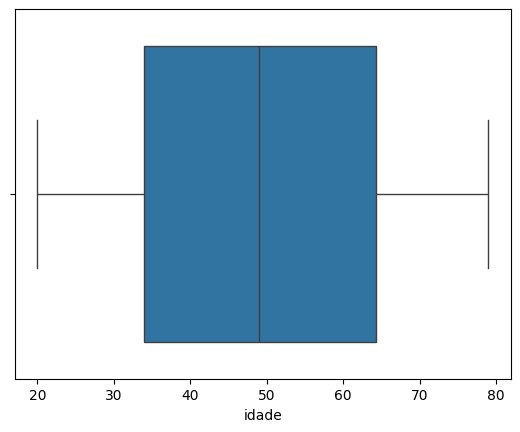

In [25]:
# BoxPlot Idade
sns.boxplot(data=df_colesterol_eda, x='idade')

<Axes: xlabel='peso'>

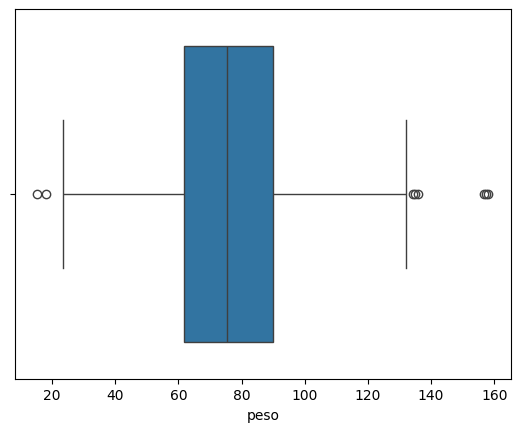

In [26]:
# BoxPlot Peso
sns.boxplot(data=df_colesterol_eda, x='peso')

In [27]:
# Filtrar público a ser removido
df_colesterol_eda[df_colesterol_eda.peso < 40].peso.count()

37

In [28]:
# Removendo pessoas com peso < 40 (37 pessoas de 1000), pela quantidade ser pequena 
# e por não fazee muito sentido para o resultado do colesterol e assim ja elimina os outliers
df_colesterol_eda.drop(df_colesterol_eda[df_colesterol_eda.peso < 40].index, axis=0, inplace=True)

<Axes: xlabel='peso'>

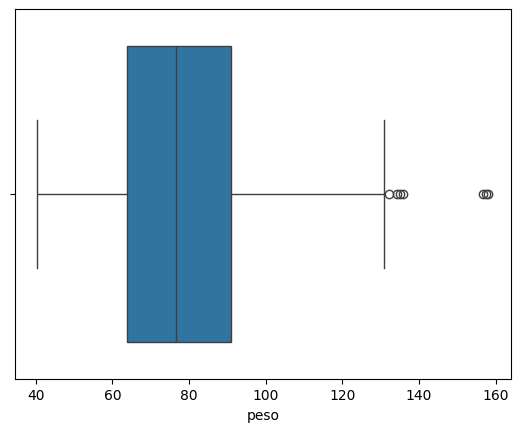

In [29]:
# BoxPlot Peso > 40
sns.boxplot(data=df_colesterol_eda, x='peso')

<Axes: xlabel='altura'>

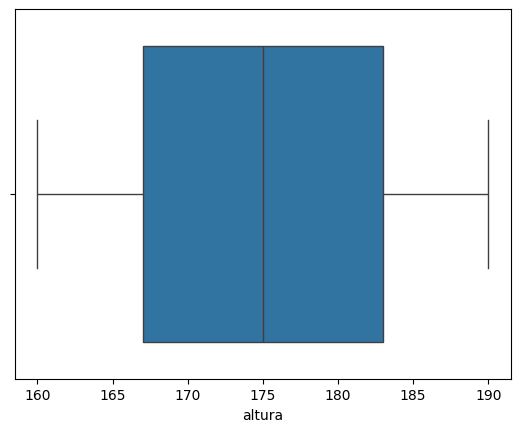

In [30]:
# BoxPlot Altura
sns.boxplot(data=df_colesterol_eda, x='altura')

<Axes: xlabel='nivel_colesterol'>

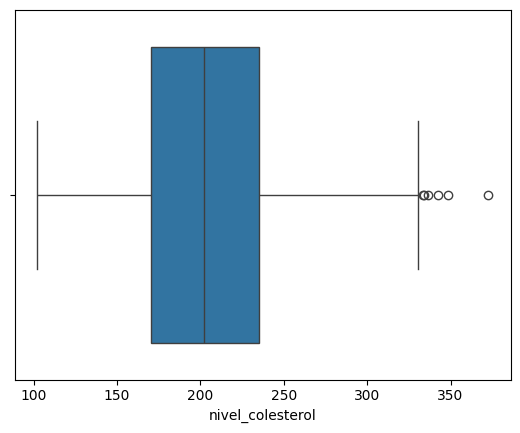

In [31]:
# BoxPlot Nivel Colesterol (Colesterol Total = Colesterol Bom + Colesterol Ruim)
# Manteremos dentro do estudo
sns.boxplot(data=df_colesterol_eda, x='nivel_colesterol')

## 3.5 - Análise Gráfica - Variáveis Categóricas x Target
- Continuaremos nossa análise exploratória de dados, agora focando em cruzamentos entre variáveis categóricas e o nível de colesterol. - Utilizaremos o boxplot para visualizar a variação do nível de colesterol de acordo com diferentes categorias, como grupo sanguíneo, tabagismo e nível de atividade física. 
- Observaremos que o grupo sanguíneo pode influenciar o nível de colesterol, com os tipos O e B apresentando níveis menores em comparação aos tipos A e AB. 
- Além disso, identificamos que fumantes tendem a ter níveis mais altos de colesterol, enquanto pessoas com alto nível de atividade física apresentam níveis mais baixos. 
- Esses padrões são importantes para a construção do modelo preditivo.

In [32]:
df_colesterol_eda.head(2)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33,85.1,186,199.63
1,A,Não,Moderado,68,105.0,184,236.98


<Axes: xlabel='grupo_sanguineo', ylabel='nivel_colesterol'>

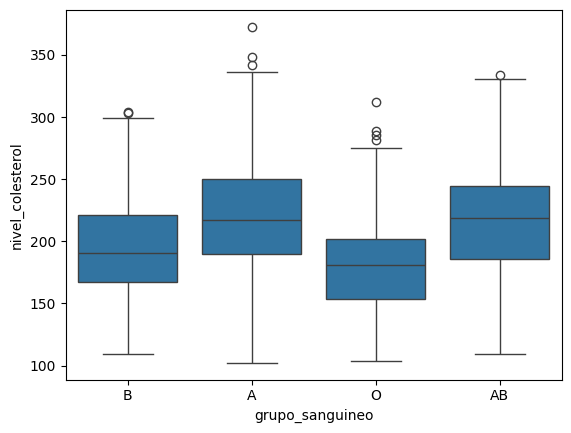

In [33]:
# Grupo_Sanguíneo x Nível_Colesterol
sns.boxplot(data = df_colesterol_eda, x='grupo_sanguineo', y='nivel_colesterol')

<Axes: xlabel='fumante', ylabel='nivel_colesterol'>

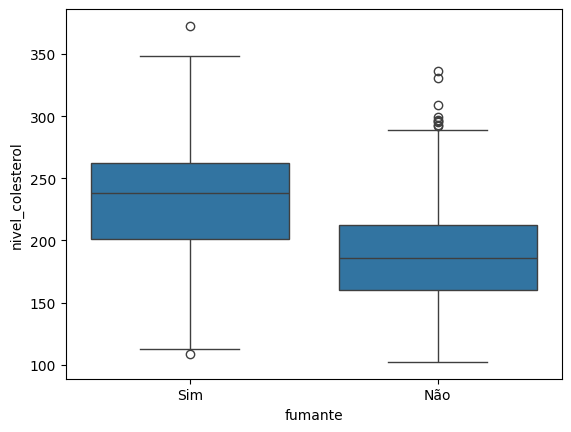

In [34]:
# Fumante x Nível_Colesterol
sns.boxplot(data = df_colesterol_eda, x='fumante', y='nivel_colesterol')

<Axes: xlabel='nivel_atividade_fisica', ylabel='nivel_colesterol'>

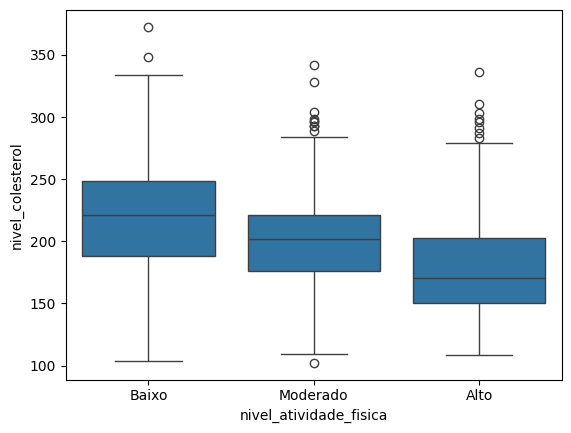

In [35]:
# Nível_Atividade_Física x Nível_Colesterol
sns.boxplot(data = df_colesterol_eda, x='nivel_atividade_fisica', y='nivel_colesterol')

## 3.6 - Análise Gráfica - Variáveis Numéricas x Target
- Analisaremos a relação entre o peso e o nível de colesterol. 
- Observaremos que, em geral, há uma tendência de que quanto maior o peso, maior o nível de colesterol. 
- No entanto, também identificamos outliers, ou seja, valores de colesterol muito altos para pesos muito altos. 
- Se encontrássemos casos de pessoas com pesos altos e níveis de colesterol baixos, seria algo estranho. 
- Em seguida, analisamos a relação entre a altura e o nível de colesterol, e não encontramos um padrão claro. 
- Concluímos essa parte da análise e nos preparamos para a próxima etapa, que é cruzar as variáveis numéricas com a variável dependente, o nível de colesterol.

In [36]:
df_colesterol_eda.head(2)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33,85.1,186,199.63
1,A,Não,Moderado,68,105.0,184,236.98


<Axes: xlabel='idade', ylabel='nivel_colesterol'>

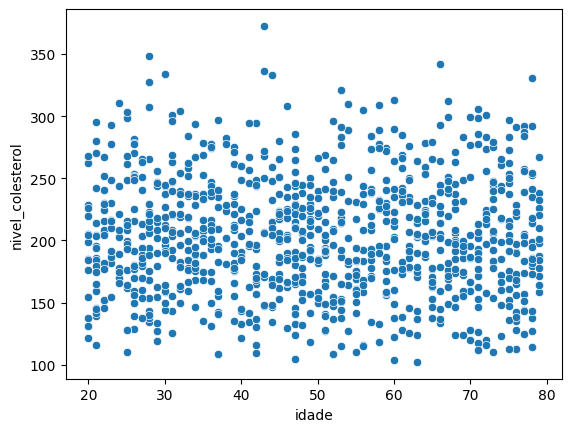

In [37]:
# Idade x Nível_Colesterol
sns.scatterplot(data = df_colesterol_eda, x='idade', y='nivel_colesterol')

<Axes: xlabel='peso', ylabel='nivel_colesterol'>

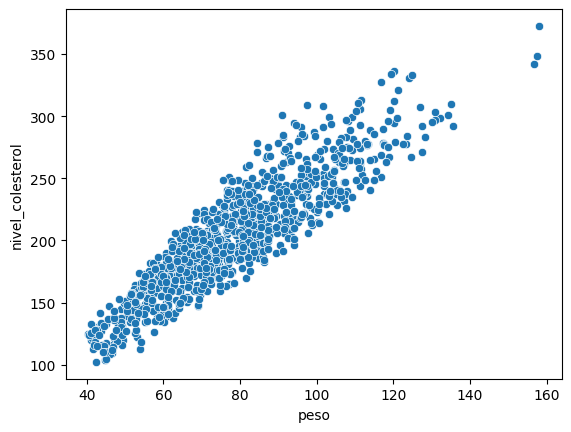

In [38]:
# Peso x Nível_Colesterol
sns.scatterplot(data = df_colesterol_eda, x='peso', y='nivel_colesterol')

<Axes: xlabel='altura', ylabel='nivel_colesterol'>

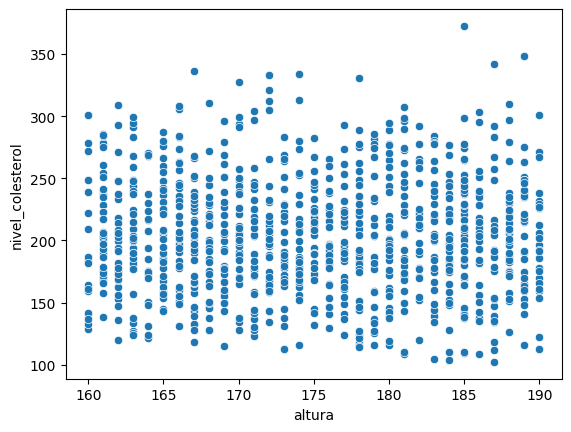

In [39]:
# altura x Nível_Colesterol
sns.scatterplot(data = df_colesterol_eda, x='altura', y='nivel_colesterol')

## 3.7 - Análise Gráfica - Histogramas
- Agora vamos analisar a distribuição das variáveis numéricas e procurar por correlações entre elas. 
- Utilizaremos o Seaborn para criar um gráfico chamado pairplot, que mostrará a distribuição das variáveis e suas correlações visuais. 
- Observaremos que o peso tem uma correlação positiva com o nível de colesterol, ou seja, quanto maior o peso, maior o nível de colesterol. 
- A altura e a idade estão bem distribuídas ao longo do conjunto de dados. 
- Não encontramos outras correlações significativas entre as variáveis independentes (o ideal é eliminar umas das duas), <u>o que é bom para evitar multicolinearidade em nosso modelo.</u>

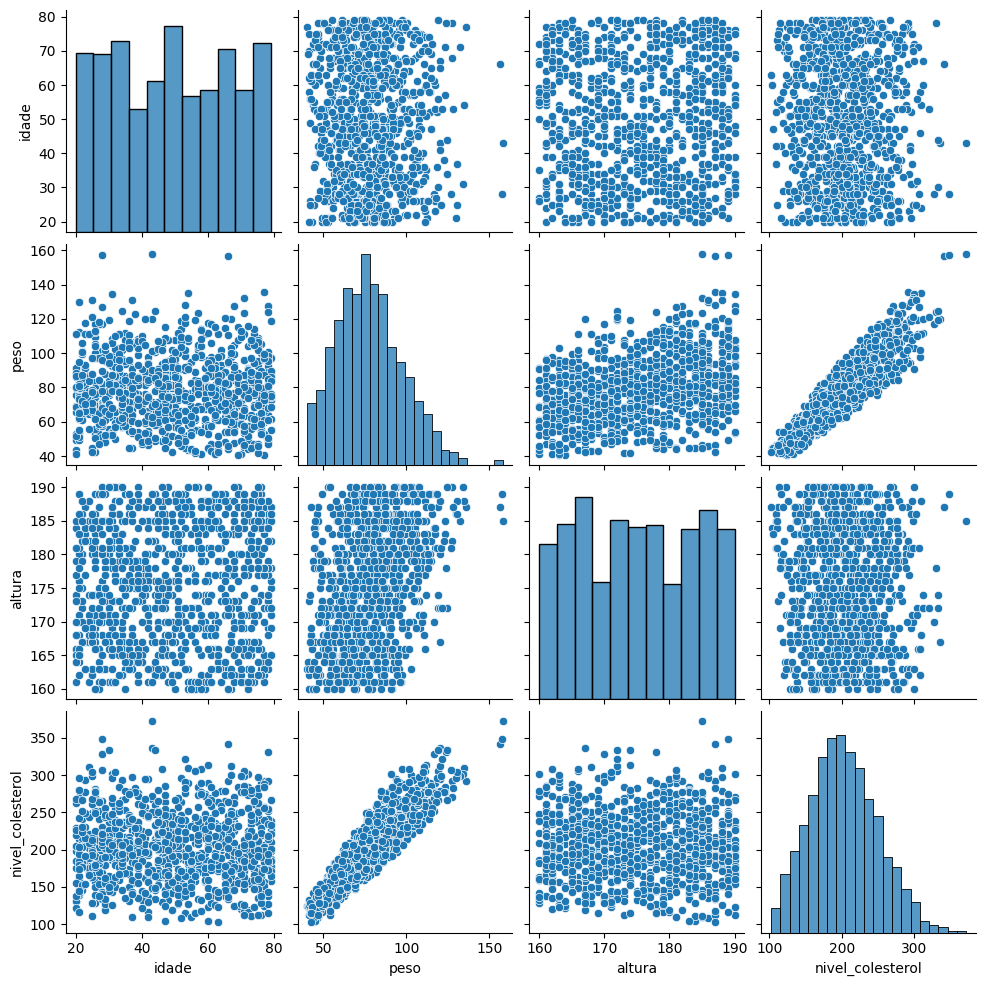

In [40]:
sns.pairplot(df_colesterol_eda)

## 3.8 - Análise de Correlação
- Agora aprenderemos como converter variáveis categóricas em numéricas para análise de correlação. 
- Utilizamos o método get_dummies do Pandas para converter as variáveis nominais, como fumante e grupo sanguíneo, em variáveis binárias.
- Em seguida, utilizamos o método factorize para converter a variável ordinal de nível de atividade física em valores numéricos. 
- Com o DataFrame preparado, plotamos um heatmap de correlação usando o Seaborn, onde observamos as correlações entre as variáveis.
- Identificamos que o peso tem uma correlação forte com o nível de colesterol, assim como o fato de ser fumante e o tipo sanguíneo.
- Também notamos uma correlação negativa entre o nível de colesterol e o nível de atividade física.

### 3.8.1 - One-Hot Encoder (Dummies e Factorize) do Pandas
- Converter Variáveis Categóricas em Numéricas.
- Para EDA utilizamos o Pandas, para o Treinamento do Modelo utilizamos o scikit-learn
<p><font color='red'> IMPORTANTE</font>
<p>O One-Hot Encoder gera um problema que se chama Dummie Variable Trap (Armadilha da Variável Dummie), causando Multicolinearidade (variáveis independentes fmuito correlacionadas entre si), e também poderia estar imputando um viés, modificando a estrutura do dado original.
<p>A variável grupo_sanguíneo gerou 4 variáveis binárias, onde a soma delas sempre resulta em 1. Uma das formas de resolver isso é excluir uma delas. Assim a soma delas poderá resultar 0 também.
<p>Para Converter Variável Categórica Ordinal (Nível Atividade Física), ou seja, que possui uma ordem, usamos o <font color='yellow'> Factorize.

In [41]:
df_colesterol_eda.head(2)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33,85.1,186,199.63
1,A,Não,Moderado,68,105.0,184,236.98


In [42]:
df_colesterol_eda = pd.get_dummies(df_colesterol_eda, columns=['grupo_sanguineo', 'fumante'], dtype='int64')

In [43]:
df_colesterol_eda.head()


,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,Baixo,33,85.1,186,199.63,0,0,1,0,0,1
1,Moderado,68,105.0,184,236.98,1,0,0,0,1,0
2,Alto,25,64.8,180,161.79,0,0,0,1,1,0
3,Alto,43,120.2,167,336.24,1,0,0,0,1,0
4,Baixo,79,88.5,175,226.23,0,1,0,0,1,0


In [44]:
# Convertemos Variável Categórica Ordinal em Numérica 
df_colesterol_eda.nivel_atividade_fisica = pd.factorize(df_colesterol_eda.nivel_atividade_fisica)[0] + 1

In [45]:
df_colesterol_eda.head()

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,1,33,85.1,186,199.63,0,0,1,0,0,1
1,2,68,105.0,184,236.98,1,0,0,0,1,0
2,3,25,64.8,180,161.79,0,0,0,1,1,0
3,3,43,120.2,167,336.24,1,0,0,0,1,0
4,1,79,88.5,175,226.23,0,1,0,0,1,0


### 3.8.2 - Mapa de Calor com Correlação Entre as Variáveis

<Axes: >

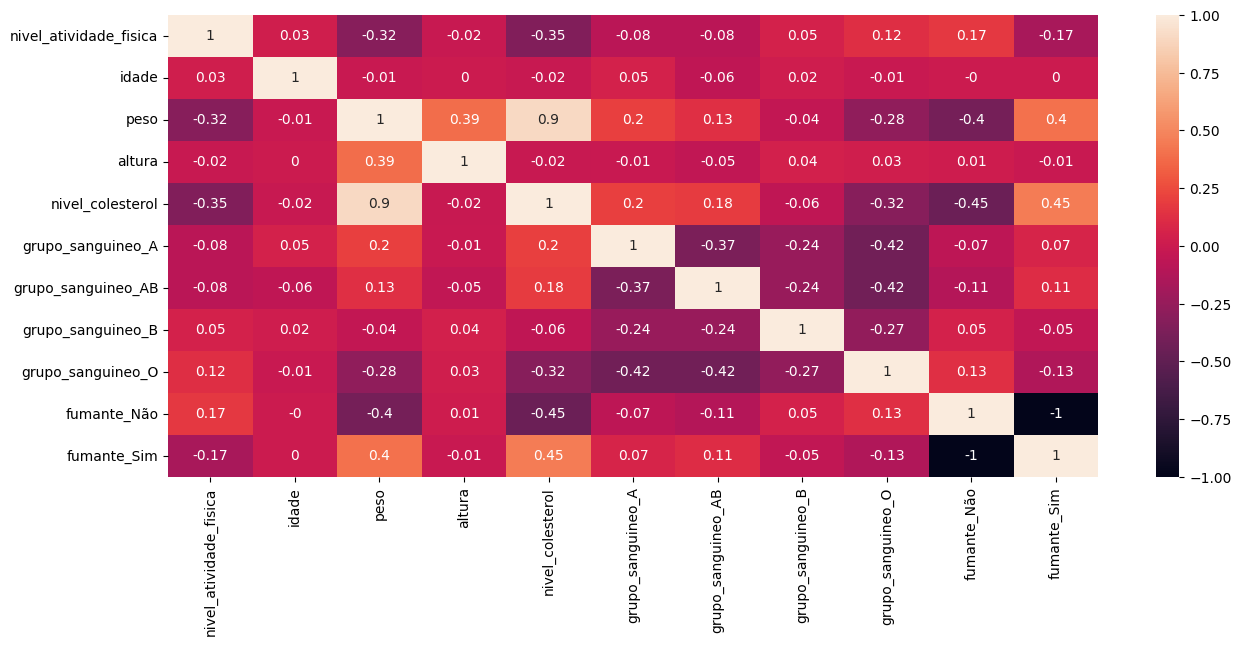

In [46]:
plt.figure(figsize=(15,6))
sns.heatmap(df_colesterol_eda.corr().round(2), vmin=-1, vmax=1, annot=True)
#df_colesterol_eda.corr().round(2)

<Axes: >

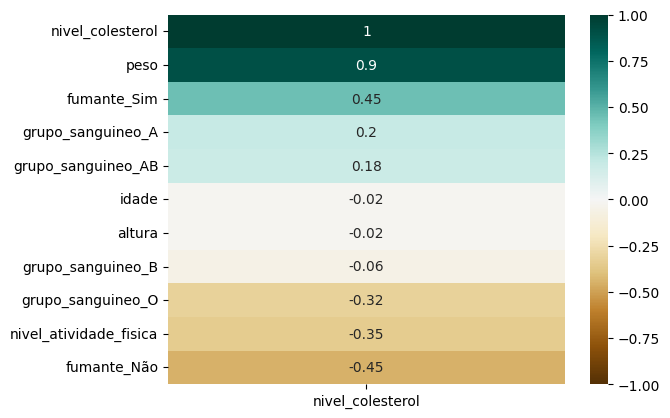

In [47]:
# Formato de Ranking, somente a correlação com a variável Target (Nível Colesterol)
sns.heatmap(df_colesterol_eda.corr()[['nivel_colesterol']].round(2).sort_values(by='nivel_colesterol', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

## 3.9 - Análise Gráfica com Bucketing
- Aprenderemos sobre o conceito de bucketing e como aplicá-lo usando a biblioteca Pandas em Python. 
- O bucketing é útil quando queremos analisar ranges de valores em vez de valores individuais. 
- No exemplo dado, criamos buckets para a variável idade, dividindo-a em faixas de 10 anos. 
- Também mostramos como fazer o mesmo para a variável peso. 
- Em seguida, utilizamos gráficos de boxplot para visualizar os agrupamentos e identificar possíveis padrões ou outliers. 
- No caso da idade, não encontramos um padrão claro em relação ao nível de colesterol, ao contrário do que aconteceu com o peso.

### 3.9.1 - Bucketing Idades

In [48]:
df_colesterol_bucketing.idade.describe().round(2)

count    997.00
mean      49.21
std       17.48
min       20.00
25%       34.00
50%       49.00
75%       65.00
max       79.00
Name: idade, dtype: float64

In [49]:
bins_idade = [20, 30, 40, 50, 60, 70, 80]
labels_idade = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df_colesterol_bucketing['escala_idade'] = pd.cut(x=df_colesterol_bucketing.idade, bins=bins_idade, labels=labels_idade, include_lowest=True)

In [50]:
df_colesterol_bucketing.head()

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala_idade
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79


<Axes: xlabel='escala_idade', ylabel='nivel_colesterol'>

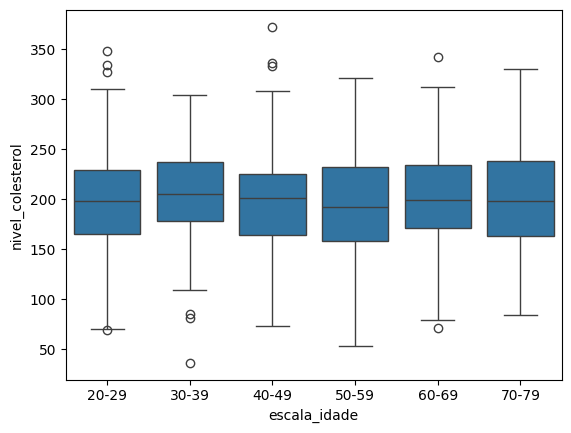

In [51]:
sns.boxplot(df_colesterol_bucketing, x='escala_idade', y='nivel_colesterol')

### 3.9.1 - Bucketing Peso

In [52]:
# Removendo pessoas com peso < 40 (37 pessoas de 1000), pela quantidade ser pequena igua do df_colesterol_eda
# e por não fazee muito sentido para o resultado do colesterol e assim ja elimina os outliers
df_colesterol_bucketing.drop(df_colesterol_bucketing[df_colesterol_bucketing.peso < 40].index, axis=0, inplace=True)

In [53]:
df_colesterol_bucketing.peso.describe().round(2)

count    960.00
mean      78.17
std       20.00
min       40.40
25%       63.78
50%       76.65
75%       91.10
max      158.10
Name: peso, dtype: float64

In [54]:
# C
bins_peso = [40, 60, 80, 100, 120, 140, 160]
labels_peso = ['40-59', '60-79', '80-99', '100-119', '120-139', '140-159']
df_colesterol_bucketing['escala_peso'] = pd.cut(x=df_colesterol_bucketing.peso, bins=bins_peso, labels=labels_peso, include_lowest=True)

In [55]:
df_colesterol_bucketing.head(10)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala_idade,escala_peso
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39,80-99
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69,100-119
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29,60-79
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49,120-139
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79,80-99
5,B,Não,Baixo,68.0,66.8,170.0,185.31,60-69,60-79
6,A,Sim,Baixo,60.0,117.3,181.0,289.33,50-59,100-119
7,O,Sim,Moderado,35.0,86.9,174.0,216.48,30-39,80-99
8,O,Não,Baixo,62.0,81.3,166.0,235.30,60-69,80-99
10,A,Sim,Baixo,57.0,123.6,183.0,283.87,50-59,120-139


<Axes: xlabel='escala_peso', ylabel='nivel_colesterol'>

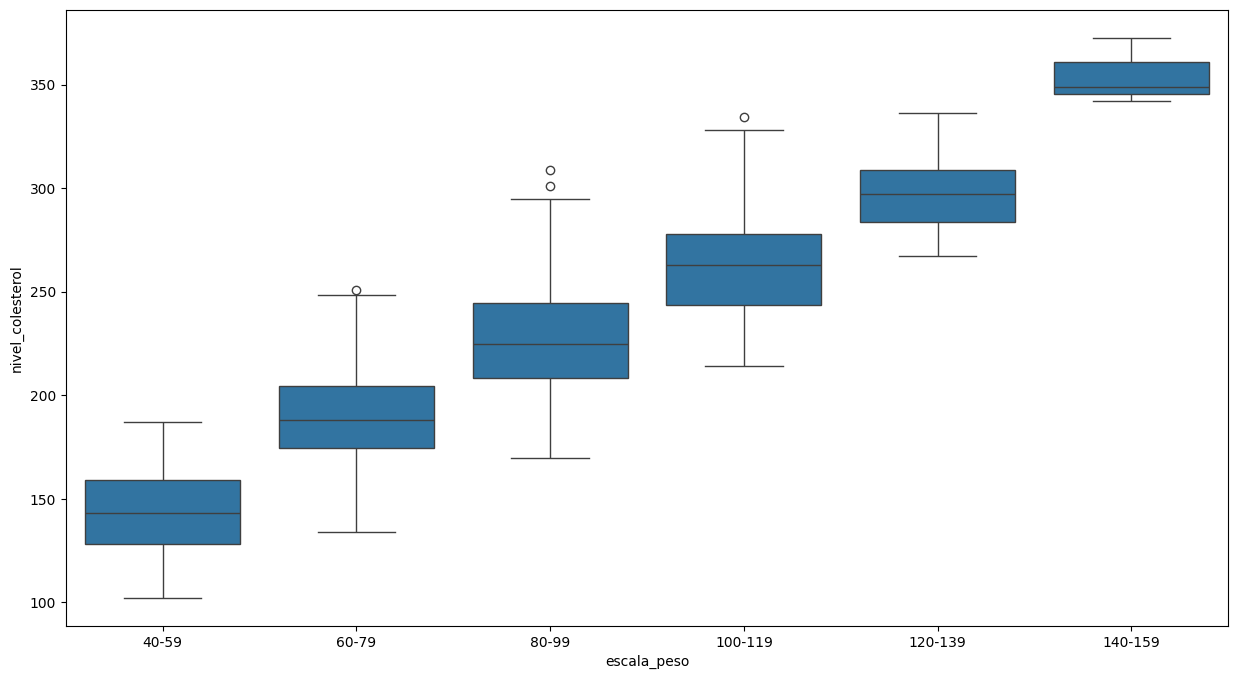

In [56]:
plt.figure(figsize=(15,8))
sns.boxplot(df_colesterol_bucketing, x='escala_peso', y='nivel_colesterol')

# 4 - Preparação do Dataset para Treinamento

## 4.1 - Split do Dataset Treino e Teste
- Dando sequência vamos começar a treinar nosso modelo de predição de colesterol com base em um conjunto de dados. 
- Para isso, vamos utilizar o conceito de pipeline do sklearn, que nos ajuda a automatizar o processo de transformação das variáveis independentes antes de entrar no modelo.
- Vamos importar os módulos necessários do sklearn, como o modelSelection, linear regression e preprocessing. 
- Também vamos utilizar o column transformer para transformar as colunas de acordo com nossa necessidade. 
- Além disso, vamos tratar os valores ausentes e importar as métricas r2score, minabsoluteerror e minsquarederror. 
- Após preparar o dataframe e fazer o split dos dados de treino e teste, vamos construir o pipeline para treinar nosso modelo.

### 4.1.1 - Criar Dataset de Treino e Teste

In [57]:
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         996 non-null    object 
 1   fumante                 997 non-null    object 
 2   nivel_atividade_fisica  996 non-null    object 
 3   idade                   997 non-null    float64
 4   peso                    997 non-null    float64
 5   altura                  997 non-null    float64
 6   nivel_colesterol        1000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 54.8+ KB


In [58]:
# Remover Pessoas com Peso < que 40kg
df_colesterol.drop(df_colesterol[df_colesterol.peso < 40].index, axis=0, inplace=True)

In [59]:
# Separação das Variáveis Independentes (X) e a Dependente (Y)
X = df_colesterol.drop(columns='nivel_colesterol', axis=1)
y = df_colesterol.nivel_colesterol

In [60]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=51)

## 4.2 - Transformação de Variáveis Categóricas para o Modelo
- Vamos aprender sobre a importância de padronizar e codificar variáveis em um pipeline de transformação de dados. 
- Primeiro, discutimos a necessidade de padronizar variáveis numéricas, como idade, altura e peso, para que todas estejam na mesma escala. 
- Em seguida, explicamos a importância de codificar variáveis categóricas nominais usando o método one-hot encode e variáveis categóricas ordinais usando o método ordinal encoder. 
- Além disso, mencionamos a importância de imputar valores ausentes usando a mediana para variáveis numéricas. 
- Por fim, mostramos como organizar um pipeline de transformação, criando uma lista de colunas para cada tipo de variável e definindo os passos de transformação para cada categoria.

### 4.2.1 - Pipeline de Transformação de Dados
Fizemos isso no EDA, agora agora faremos dentro de um <u>pipeline</u> quando treinar o modelo<br>
- Imputar moda nas variáveis categóricas <font color=yellow>(Grupo sanguíneo, fumante, nível atividade física)</font>
- Padronizar variáveis numéricas <font color=yellow>(idade, peso, altura)</font>
- OneHot Enconder nas variáveis categóricas nominais <font color=yellow>(Grupo sanguíneo, fumante)</font>
- Ordinal Enconder nas variáveis categóricas ordinais <font color=yellow>(nível atividade fisica)</font>
- Imputar mediana nas variáveis numéricas <font color=yellow>(idade, peso e altura)</font><br><br>
<font color=lightgreen>Organização do pipeline</font>
1. Nomes das Colunas
2. Transformação das Categorias
3. Etapa1<br><br>
<font color=red>Regra de Ouro:</font>
Qualquer método de transformação dos dados deve ser feita sempre depois do split dos dados, para que não ocorra <u>vazamento de dados (Data Leakage),</u> que é quando ocorre quando informações que não estariam disponíveis durante o uso prático do modelo são acidentalmente incluídas no processo de treinamento ou validação.<br><br>
<font color=yellow>O que o Pipeline do Sklearn faz: 'Pesquisar mais sobre esse assunto'</font>
1.  Treina o transformador no conjunto de testes
2. Depois transforma no conjunto de treino e depois no conjunto de teste, ele não faz um fit(treino e teste) nos dois conjuntos, ou seja, treina em um conjunto e aplica no outro, dessa forma não vaza os dados.


In [61]:
# Nomes das colunas
colunas_categoricas_nominais = ['grupo_sanguineo', 'fumante']
colunas_numericas =  ['idade', 'altura', 'peso']
colunas_categoricas_ordinais = ['nivel_atividade_fisica']

In [62]:
# Transformação das categorias Nominais: igual feito no EDA, mas usando o Pipeline
transformer_categoricas_nominais = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

## 4.3 - Transformação de Variáveis Ordinais e Numéricas para o Modelo
- Continuamos a nossa pipeline criando um Transformer para as variáveis ordinais. 
- O Transformer irá realizar a mesma função do Imputer, preenchendo os valores ausentes com a moda. 
- A diferença é que precisamos definir a ordem das categorias, que são baixa, moderada e alta. 
- Em seguida, criamos um Transformer numérico, utilizando a mediana como estratégia de preenchimento dos valores ausentes. 
- Em vez de usar um encoder, utilizamos um Scalar, especificamente o Standard Scalar, para converter os valores para a escala Z. 
- Após criar esses três Transformers, encapsulamos todos eles em um Column Transformer, que será o pré-processador antes de treinar o modelo.

In [63]:
# Transformação das categorias Ordinal: igual feito no EDA, mas usando o Pipeline
transformer_categoricas_ordinais = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories= [['Baixo', 'Moderado', 'Alto']], handle_unknown='error'))
])

In [64]:
# Transformação das Numéricas: igual feito no EDA, mas usando o Pipeline
transformer_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

### 4.3.1 - ColumnTransform que Encapsula todas as Transformações 

In [65]:
# Preprocessador, que encapsula todos os transformers anteriores, onde fará parte do pipeline geral que treinará o modelo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas),
        ('cat', transformer_categoricas_nominais, colunas_categoricas_nominais),
        ('ord', transformer_categoricas_ordinais, colunas_categoricas_ordinais)
    ]
)

# 5 - Treinamento do Modelo com Pipelines

## 5.1 - Construção do Pipeline e Treinamento do Modelo
- Criaremos um Pipeline principal para pré-processar os dados e treinar um modelo de regressão linear. 
- O Pipeline é composto por dois steps: 
1. o pré-processamento, que transforma as colunas no formato necessário, 
2. e o treinamento do modelo. 
- Utilizamos o objeto Pipeline para criar essa estrutura. 
- Em seguida, treinamos o modelo utilizando o método fit, passando o conjunto de treinamento. 
- O Pipeline executa todas as etapas de uma vez, incluindo o pré-processamento e a regressão linear. 
- Podemos visualizar a estrutura do Pipeline e analisar as métricas do modelo treinado.

In [66]:
# Pipeline Principal = Pré processamento + Treinamento
model_regression = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', LinearRegression())])

In [67]:
# Treinar Modelo
model_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'altura', 'peso']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grupo_sanguineo',
                                                   'fumante']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Baixo',
                                                                                               'Moderado',
                                                                                               'Alto']]))]),
                                                  ['nivel_atividade_fisica'])])),
                ('regressor', LinearRegression())])

# 6 -Validação do Modelo

## 6.1 - Análise de Métricas
- Vamos analisar as métricas do nosso modelo de predição. 
- Primeiro, vamos gerar a predição usando o conjunto de teste. 
- Em seguida, calcularemos o <font color=#FFECA1>R2Score</font>, que mede o quão bem as variáveis independentes explicam a variância da variável dependente. Um valor próximo de 1 indica um bom modelo. 
- Também calcularemos o <font color=#FFECA1>MeanAbsoluteError</font>, que mede a diferença média entre os valores preditos e reais, e o <font color=#FFECA1>RRMSE</font>, que leva em conta os outliers. 
- Vamos analisar essas métricas para avaliar a qualidade do nosso modelo.

### 6.1.1 - Gerar a Predição

In [68]:
y_pred = model_regression.predict(X_test)

### 6.1.2 - Calcular as Métricas

In [69]:
# R2Score
r2_score(y_test, y_pred)

0.9594250724093464

In [70]:
# MAE (Mean Absolute Error): Significa que errou na média o resultado do colesterol em ou +7.31 ou -7.31
mean_absolute_error(y_test, y_pred)

7.313838031022503

In [71]:
# RRMSE (Root Mean Absolute Error): Leva em consideração os outliers
mean_squared_error(y_test, y_pred, squared=False)

c:\Users\rgreb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.097649246487032

## 6.2 - Análise Gráfica de Resíduos
- Vamos analisar os resíduos do nosso modelo de regressão. 
- Vamos calcular os resíduos e transformá-los na escala padrão. 
- Em seguida, faremos uma análise gráfica para verificar a linearidade e a homoscedasticidade dos resíduos. 
- Utilizaremos o scatter plot do Seaborn para plotar o gráfico. 
- Observaremos se os valores estão próximos da reta de 45° e se estão dentro da banda de segurança.
- Além disso, faremos testes estatísticos para confirmar se os resíduos seguem uma distribuição normal. 
- Utilizaremos o gráfico QQ-Plot do módulo Penguin para verificar a normalidade dos resíduos.

### 6.2.1 - Calcular Resíduos
Resíduo é um erro que é dado pela <u>diferença entre o valor real da varíável (y_test) e a variável predita (y_pred)</u>: y_test - y_pred

In [72]:
# Calcular Resísuos
residuos = y_test - y_pred

### 6.2.3 - Converter para uma escala padronizada (standardization)

In [73]:
# Transformar Resíduos na Escala Padrão
# (x - media) / desvio_padrão 
residuos_std = zscore(residuos)

### 6.2.2 - Depois de convertê-los para uma escala padronizada faremos a Análise Gráfica com testes
- Primeiro teste no gráfico: Verificar a linearidade do modelo: Se os Resíduos estiverem entre -2 e +2 (na escala padrão) - indica linearidade dos resíduos
- Segundo teste no gráfico: Verificar a homogeneidade das variâncias (Homocedasticidade): Se os valores estiver em torno da reta, temos homocedasticidade, caso contrário se tivermos alguma tendência ou padrão (forma de um cone ou funil), há Heterocedastidade.

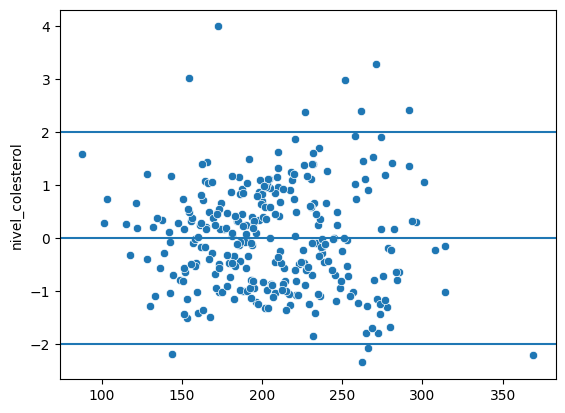

In [74]:
# Verificar a Linearidade dos resíduos: Valores entre -2 e +2 (Escala Padrão)
# Verificar homocedasticidade: valores em torno da reta
sns.scatterplot(x=y_pred, y=residuos_std)
plt.axhline(y=-2)
plt.axhline(y=0)
plt.axhline(y=2)

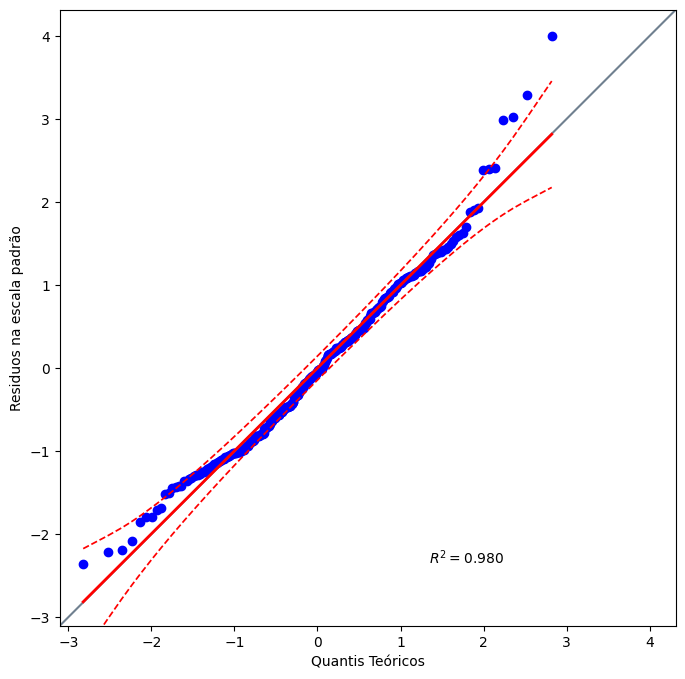

In [75]:
# Checar se resíduos seguem uma distribuição normal
# QQ Plot
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Residuos na escala padrão')
plt.show()

## 6.3 - Teste de Normalidade dos Resíduos
- Vamos realizar testes estatísticos para verificar a normalidade dos resíduos. 
- Vamos utilizar os testes de <font color=#A2FFB0>Shapiro-Wilk, Kolmogorov-Smirnov, Lillliefors e Anderson-Darling.</font>
- Primeiro, importamos os módulos necessários do SciPy e StatsModels. 
- Em seguida, executamos o teste de Shapiro-Wilk, que retorna a estatística do teste e o valor P. Se o valor P for menor que 0.005, podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal. 
- Em seguida, realizamos o teste de Kolmogorov-Smirnov, que também indica a falta de normalidade nos resíduos. 
- Por fim, realizamos o teste de Lillliefors, que indica a normalidade dos resíduos. 
- Para complementar, realizamos o teste de Anderson-Darling, comparando a estatística do teste com os valores críticos para diferentes níveis de significância. 
- Concluímos que três dos quatro testes indicam a falta de normalidade nos resíduos.

### 6.3.1 - Teste de Normalidade de Shapiro-Wilk
Retorna a estatística do teste e o valor P. Se o valor P for menor que 0.005, podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal.
- Hipótese nula(H0): segue uma distribuição normal
- H1: Não segue uma distribuição normal
- Se o P-valor > 0.05 não rejeitamos H0, caso contrário sim

In [76]:
# Pelo teste de Shapiro Wilk (P < 0.005), rejeitamos o H0 e os resíduos não seguem uma distribuição normal
stat_shapiro, p_valor_shapiro = shapiro(residuos)
print('Estatística do teste: {} e P-Valor: {}'.format(stat_shapiro, p_valor_shapiro))

Estatística do teste: 0.9807737729720729 e P-Valor: 0.0006268860444489818


### 6.3.2 - Teste de Kolmogorov-Smirnov

In [77]:
# Toda vez que trabalhar com número científico, podemos tranformar em um decimal para ficar mais coompreensivo
pd.set_option('display.float_format', lambda x: '%.15f' % x)

In [78]:
# P-Valor = 8.92. Pelo teste de Kolmogorov-Smirnov (P < 0.005), rejeitamos o H0 e os resíduos não seguem uma distribuição normal.
# P = 8.92583319090192/-48 ou seja P = -0.18
stat_ks, p_valor_ks = kstest(residuos, 'norm')
print('Estatística do teste: {} e P-Valor: {}'.format(stat_ks, p_valor_ks))

Estatística do teste: 0.42455920998485785 e P-Valor: 8.92583319090192e-48


In [79]:
8.92583319090192/-48

-0.18595485814379

### 6.3.3 - Teste de Lillliefors

In [80]:
# P-Valor = 0.12. Pelo teste de Lilliefors (P > 0.005), não rejeitamos o H0 e os resíduos seguem uma distribuição normal.
stat_ll, p_valor_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print('Estatística do teste: {} e P-Valor: {}'.format(stat_ll, p_valor_ll))

Estatística do teste: 0.049553710301929066 e P-Valor: 0.12533323720735978


### 6.3.4 - Teste de Anderson-Darling

In [81]:
stat_and, critical_and, significance_and = anderson(residuos, dist='norm')

In [82]:
critical_and

array([0.568, 0.647, 0.776, 0.906, 1.077])

In [83]:
significance_and

array([15. , 10. ,  5. ,  2.5,  1. ])

In [84]:
# Se a estatística é maior que o valor crítico, posso rejeitar H0 e os resíduos não seguem uma distribuição normal
print('Estatística do teste: {} e Valor Crítico: {}'.format(stat_and, critical_and[2]))

Estatística do teste: 0.9169275158490109 e Valor Crítico: 0.776


## 6.4 - Teste de Homocedasticidade dos Resíduos: Goldfeld-Quandt 
- Discutimos sobre o teste estatístico de homoscedasticidade, especificamente o teste de <font color=#A2FFB0>Goldfeld-Quandt.</font> 
- Para realizar esse teste, é necessário preparar os dados, incluindo os resíduos e as variáveis independentes. 
- Criamos anteriormente um pipeline completo (Pré Processamento + Treinamento), <font color=#A2FFB0>agora precisamos criar um novo pipeline apenas para pré-processamento.</font> 
- Em seguida, aplicamos o pipeline aos dados de teste e executamos o teste de Goldfeld-Quandt. 
- Os resultados mostraram que não podemos rejeitar a hipótese nula, indicando que os resíduos têm variância homogênea em relação às variáveis independentes. 
- Isso é um bom sinal para o modelo. Com isso, concluímos a análise de resíduos e estamos prontos para fazer previsões e entregar o modelo ao usuário final.

In [85]:
# Pipeline Pré Processamento
pipe = Pipeline(steps=[('preprocessor', preprocessor)])
X_test_trasnformed = pipe.fit_transform(X_test) # Treinar e já transformar os dados originais do conjunto

In [86]:
X_test_trasnformed

array([[-1.44340738, -0.58669129,  0.22608781, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.28157488, -1.05685776, -1.20886474, ...,  1.        ,
         0.        ,  0.        ],
       [-1.10973608, -0.35160806, -0.84754575, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.00250157, -1.52702423, -1.09014564, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.28056099, -0.35160806,  0.17447081, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.72545605, -1.17439938, -1.65277092, ...,  0.        ,
         1.        ,  0.        ]])

In [87]:
# Executando o teste de Goldfeld-Quandt
# Os resultados mostraram que não podemos rejeitar a hipótese nula, indicando que os resíduos têm variância homogênea em relação às variáveis independentes. 
# Isso é um bom sinal para o modelo. Com isso, concluímos a análise de resíduos e estamos prontos para fazer previsões e entregar o modelo ao usuário final.
test_goldfeld = het_goldfeldquandt(residuos, X_test_trasnformed)
stat_goldfeld = test_goldfeld[0]
p_value_goldfeld = test_goldfeld[1]
print('Estatística do teste: {} e P-Value: {}'.format(stat_goldfeld, p_value_goldfeld))

Estatística do teste: 0.6716135765253543 e P-Value: 0.9893959472385484


# 7 - Predição de Valores e Salvando o Modelo
- Nesta parte final do modelo, vamos aprender como fazer uma predição individual usando o modelo que construímos. 
- Vamos passar os valores desejados para o modelo e ver qual valor ele retorna. 
- É importante lembrar que, no nosso caso, temos uma lista de variáveis para passar. Essas variáveis precisam ser convertidas para que possam entrar no modelo. É aí que entra a beleza dos pipelines. Como já criamos um pipeline, ele já está pronto para receber os dados no seu estado natural e fazer a conversão necessária antes de rodar o modelo e nos trazer a predição. 
- Vamos criar um dicionário com os dados que queremos prever, usando os mesmos nomes de variáveis do nosso dataset. 
- Quando salvamos o modelo, ele salva o pipeline inteiro, não apenas o modelo de regressão linear. Vamos salvar o modelo em um arquivo chamado modelo_colesterol.pkl. 
- Com isso, concluímos a parte de modelagem e salvamos o modelo.

## 7.1 - Realizar Predições Individuais

In [88]:
# Dicionario
predicao_individual = {
    'grupo_sanguineo': 'O',
    'fumante': 'Não',
    'nivel_atividade_fisica': 'Alto',
    'idade': 40,
    'peso': 70,
    'altura': 180
    }
# com base no dicionário criar um Data Frame
sample_df = pd.DataFrame(predicao_individual, index=[1])

In [89]:
sample_df.head()

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura
1,O,Não,Alto,40,70,180


In [90]:
# Predição
model_regression.predict(sample_df)

array([165.32375099])

## 7.2 - Salvar Modelo

In [91]:
# Salva o Pipeline inteiro, não só o modelo de regressão linear
joblib.dump(model_regression, './modelo_colesterol.pkl')

['./modelo_colesterol.pkl']

In [92]:
df_colesterol.columns

Index(['grupo_sanguineo', 'fumante', 'nivel_atividade_fisica', 'idade', 'peso',
       'altura', 'nivel_colesterol'],
      dtype='object')